Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models ,regularizers
from tensorflow.keras.models import Sequential
from glob import glob
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Step 1: Data Reading/Data Understanding → Defining the path for train and test images


train_dir = '/content/drive/MyDrive/data/Train/'
test_dir = '/content/drive/MyDrive/data/Test/'

# Function to ignore hidden files like .DS_Store
def listdir_no_hidden(path):
    return [f for f in os.listdir(path) if not f.startswith('.')]

# List directories in train and test paths
train_classes = listdir_no_hidden(train_dir)
test_classes = listdir_no_hidden(test_dir)

print("Classes in Train Data:")
print(train_classes)

print("\nClasses in Test Data:")
print(test_classes)

Classes in Train Data:
['pigmented benign keratosis', 'melanoma', 'nevus', 'squamous cell carcinoma', 'dermatofibroma', 'actinic keratosis', 'vascular lesion', 'seborrheic keratosis', 'basal cell carcinoma']

Classes in Test Data:
['melanoma', 'pigmented benign keratosis', 'nevus', 'vascular lesion', 'basal cell carcinoma', 'dermatofibroma', 'actinic keratosis', 'squamous cell carcinoma', 'seborrheic keratosis']


### Create a dataset



Use 80% of the images for training, and 20% for validation.

In [ ]:
#step2 : Dataset Creation

batch_size = 32
img_size = (180, 180)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=123,  # Ensures reproducibility
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Display dataset information
print(f"Train dataset: {train_ds}")
print(f"Validation dataset: {val_ds}")


class_names = train_ds.class_names
print(class_names)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

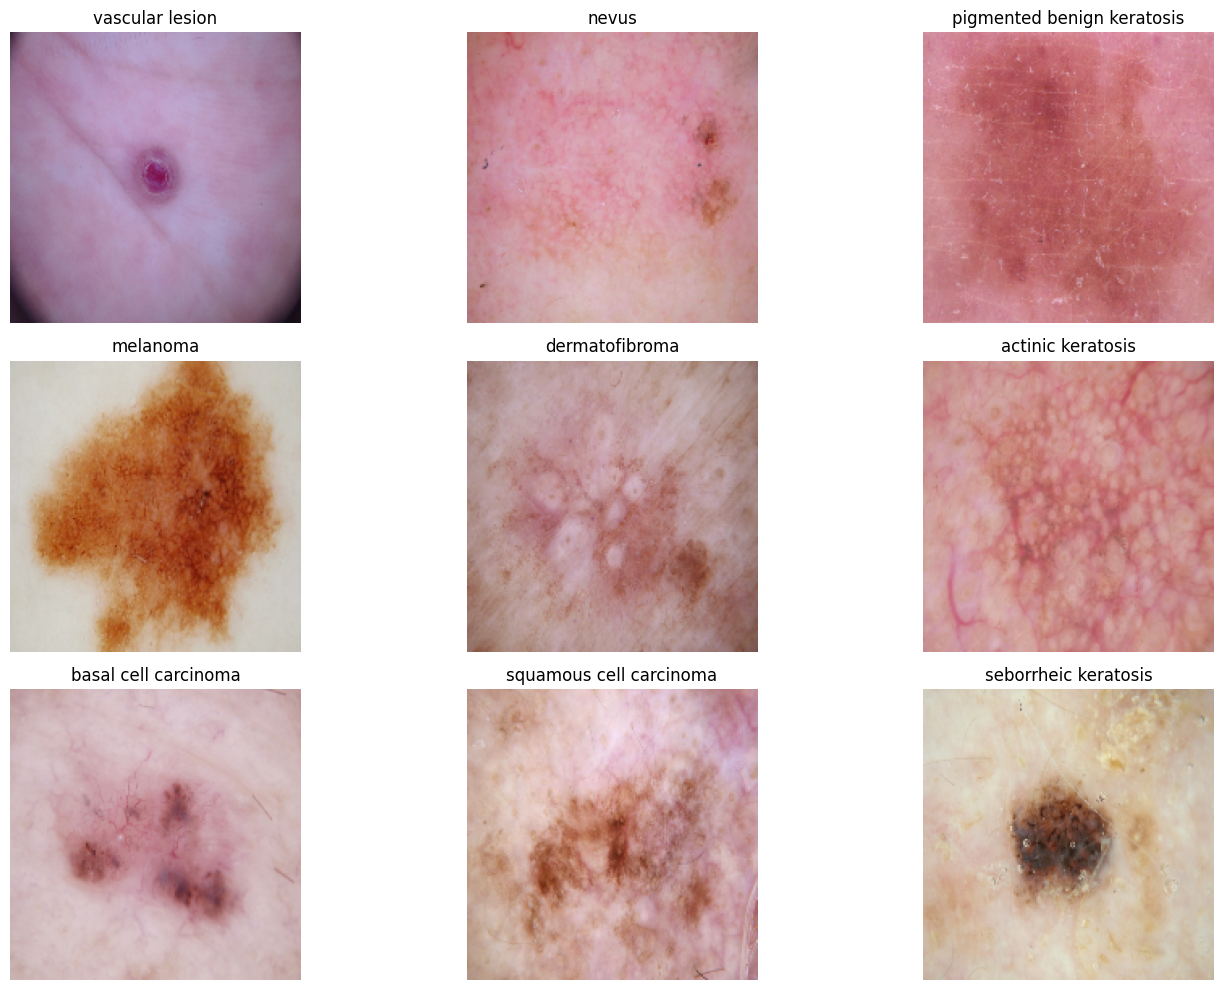

In [ ]:
#step3: Dataset visualisation


def visualize_one_instance_per_class(dataset, class_names):
    # Dictionary to track if a class instance has been displayed
    displayed_classes = {class_name: False for class_name in class_names}

    plt.figure(figsize=(15, 10))
    count = 0

    for images, labels in dataset:
        for img, label in zip(images, labels):
            class_name = class_names[label]
            if not displayed_classes[class_name]:
                count += 1
                displayed_classes[class_name] = True
                plt.subplot(3, 3, count)
                plt.imshow(img.numpy().astype("uint8"))
                plt.title(class_name)
                plt.axis("off")

            # Break if all classes are visualized
            if count == len(class_names):
                break
        if count == len(class_names):
            break

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_one_instance_per_class(train_ds, class_names)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
# Rescale images to normalize pixel values between (0, 1)
normalization_layer = layers.Rescaling(1.0 / 255)

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([

        layers.InputLayer(input_shape=input_shape),

        normalization_layer,  # Normalize pixel values

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),  # Regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

# Create the model
input_shape = (180, 180, 3)  # Image dimensions
num_classes = len(class_names)
model = create_cnn_model(input_shape, num_classes)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.2316 - loss: 2.2134 - val_accuracy: 0.4743 - val_loss: 1.6050
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4243 - loss: 1.6747 - val_accuracy: 0.5302 - val_loss: 1.5002
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4852 - loss: 1.5051 - val_accuracy: 0.5168 - val_loss: 1.4401
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5302 - loss: 1.4000 - val_accuracy: 0.4944 - val_loss: 1.5550
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5172 - loss: 1.3518 - val_accuracy: 0.4922 - val_loss: 1.4321
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5549 - loss: 1.2989 - val_accuracy: 0.5257 - val_loss: 1.4998
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5661 - loss: 1.2668 - val_accuracy: 0.5078 - val_loss: 1.3820
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5760 - loss: 1.1745 - val_accuracy: 0.5280 - v

### Visualizing training results

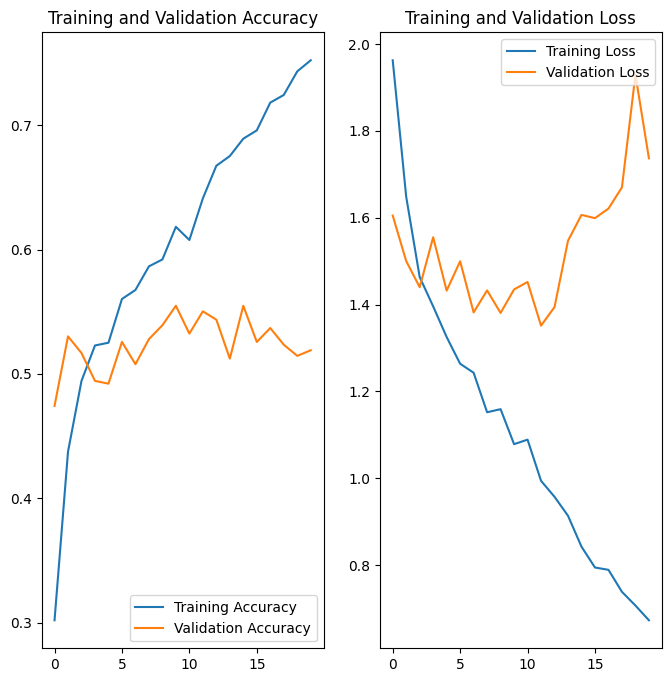

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [ ]:
# Findings

#Training Perfoemance:
#Training Accuracy: Improved steadily from 23% to 76% over 20 epochs, indicating the model is learning.
#Training Loss: Reduced significantly from 2.2 to 0.69, showing convergence in training.

#Validation Performance:
#Validation Accuracy: Improved initially (47% to 51%) but plateaued
#Validation Loss: reduced marginally from 1.6 tp 1.7.


#Evidence of Overfitting:
#The gap between training accuracy (76) and validation accuracy (51) indicates overfitting.

In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1)
])

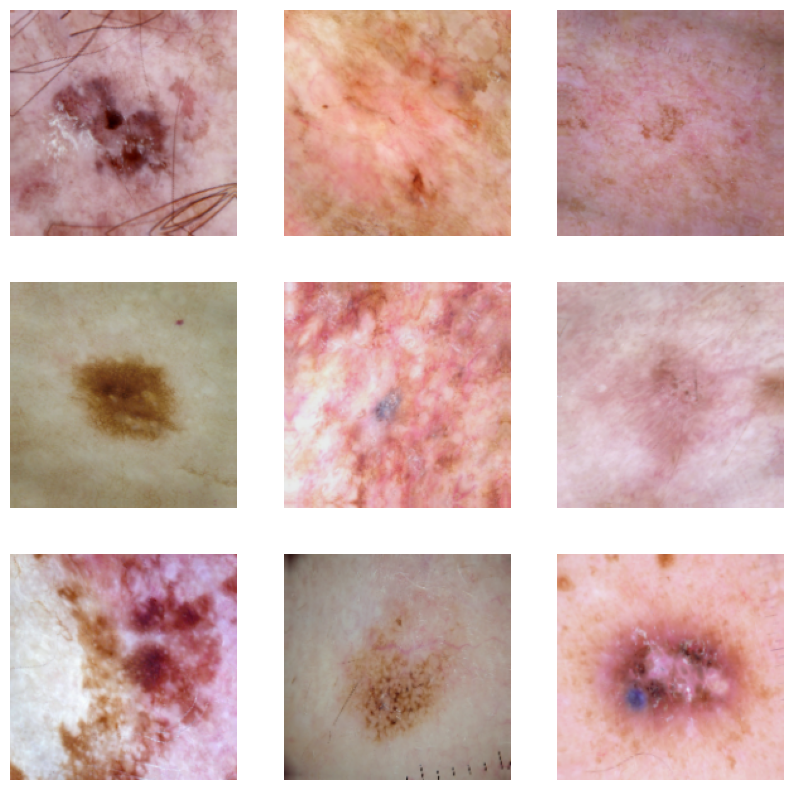

In [ ]:
# visualize after data augmentation strategy
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

### Todo:
### Create the model, compile and train the model


In [ ]:
# Incorporated
# added data augmentation layer
# added dropouts at every layer

# Define the CNN model
def create_cnn_model2(input_shape, num_classes):
    model = models.Sequential([

        layers.InputLayer(input_shape=input_shape),

        data_augmentation,

        normalization_layer,  # Normalize pixel values

        # Convolutional Layers
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),  # Dropout Layer

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(9, activation='softmax')  # 9 classes
    ])
    return model

# Create the model
input_shape = (180, 180, 3)  # Image dimensions
num_classes = len(class_names)
model2 = create_cnn_model2(input_shape, num_classes)


### Compiling the model

In [ ]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [ ]:
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.1795 - loss: 3.4238 - val_accuracy: 0.2148 - val_loss: 2.1054
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.1950 - loss: 2.0738 - val_accuracy: 0.1902 - val_loss: 2.1005
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.2018 - loss: 2.0388 - val_accuracy: 0.2841 - val_loss: 1.9906
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.2606 - loss: 1.9764 - val_accuracy: 0.3378 - val_loss: 1.8868
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.2504 - loss: 1.9720 - val_accuracy: 0.2170 - val_loss: 1.9505
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.2430 - loss: 1.9759 - val_accuracy: 0.3110 - val_loss: 1.8606
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.3070 - loss: 1.8822 - val_accuracy: 0.3557 - val_loss: 1.8755
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.3236 - loss: 1.8182 - val_accuracy: 0.4072 - v

### Visualizing the results

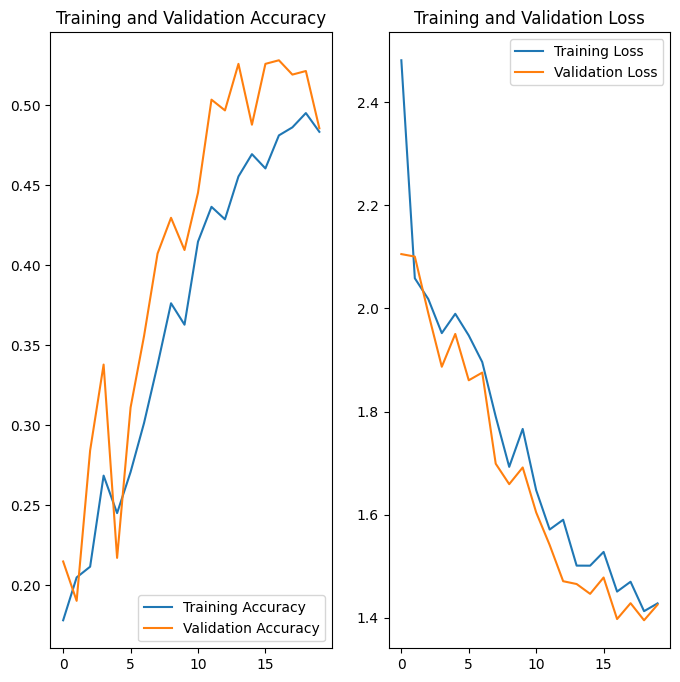

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

In [ ]:
# Findings

#Training Accuracy and Loss:
#The training accuracy increased slowly, stabilizing around 47% by the 20th epoch.
#The training loss decreased steadily, indicating the model is learning the patterns in the training data.

#Validation Accuracy and Loss:
#Validation accuracy reached 48%, slightly better than the training accuracy, indicating there is no strong evidence of overfitting.
#The validation loss decreased steadily


#Evidence of Underfitting:
#Both training and validation accuracy are relatively low.
#The gap between training and validation accuracy/loss is small, indicating that the model isn't overfitting.
#The model might not yet be complex enough or trained for enough epochs.


# Suggestions
#1. Model Complexity:
  #Increase the depth of the CNN by adding more convolutional layers.
  #Use a larger number of filters in each layer (e.g., 64 → 128 → 256).
#2. Epochs:
  #Train for more epochs (e.g., 50) to allow the model to learn further.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class Distribution in Training Dataset:
pigmented benign keratosis: 462 samples
melanoma: 438 samples
nevus: 357 samples
squamous cell carcinoma: 181 samples
dermatofibroma: 95 samples
actinic keratosis: 114 samples
vascular lesion: 139 samples
seborrheic keratosis: 77 samples
basal cell carcinoma: 376 samples


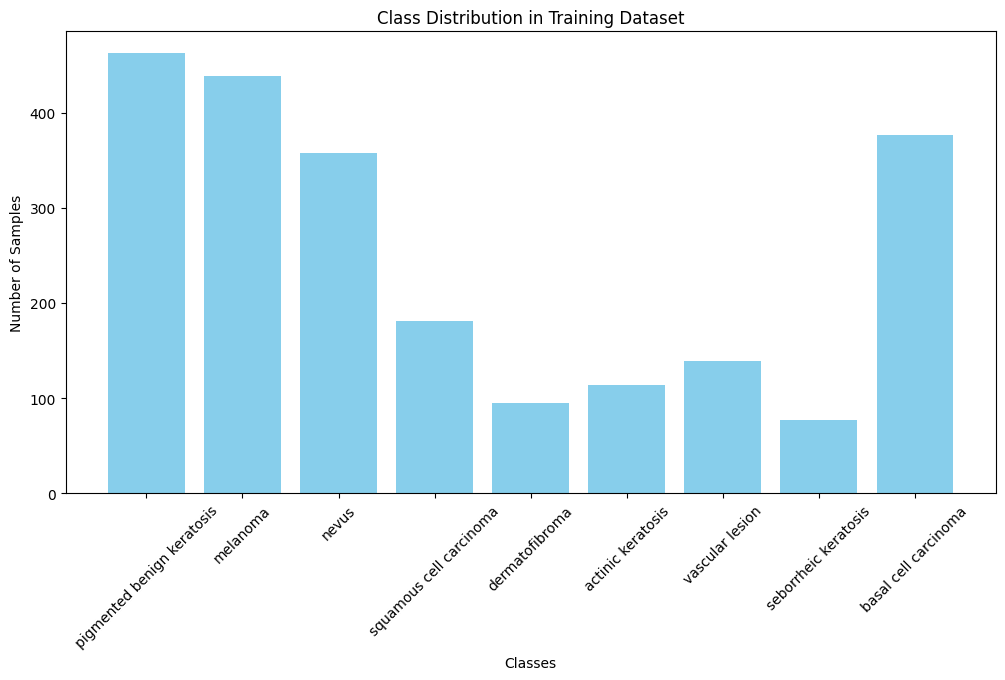

In [ ]:
class_names = os.listdir(train_dir)
class_names = [name for name in class_names if not name.startswith('.')]

# Count the number of samples in each class
class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names}

# Display the class distribution
print("Class Distribution in Training Dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} samples")

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


In [ ]:
# least number of samples: Seborrheic keratosis
# hightest number of samples: Melanoma ,Pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
import Augmentor
path_to_training_dataset = train_dir

# Get class names from the directories of the training dataset
class_names = os.listdir(path_to_training_dataset)
class_names = [name for name in class_names if not name.startswith('.')]

# Perform image augmentation for each class
for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)
    p = Augmentor.Pipeline(class_path)

    # Apply augmentations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # Sample 500 images for each class
    p.sample(500)

Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A23805C87F0>: 100%|██████████| 500/500 [01:42<00:00,  4.87 Samples/s]


Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A2380ED3460>: 100%|██████████| 500/500 [00:22<00:00, 21.92 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A2380541540>: 100%|██████████| 500/500 [00:45<00:00, 11.03 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A238053E560>: 100%|██████████| 500/500 [00:21<00:00, 23.58 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A23A652B220>: 100%|██████████| 500/500 [00:23<00:00, 21.37 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7A23815241F0>: 100%|██████████| 500/500 [01:34<00:00,  5.31 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A23811647F0>: 100%|██████████| 500/500 [00:23<00:00, 21.05 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/data/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A23805C8BE0>: 100%|██████████| 500/500 [00:22<00:00, 22.34 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A23814365C0>: 100%|██████████| 500/500 [00:24<00:00, 20.65 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(glob(os.path.join(path_to_training_dataset, '*', 'output', '*.jpg'))))
print(f"Total augmented images: {image_count_train}")

Total augmented images: 4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(path_to_training_dataset, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/data/Train/melanoma/output/melanoma_original_ISIC_0010241.jpg_4d4c9f98-0fff-4c90-87db-001b772e59c7.jpg',
 '/content/drive/MyDrive/data/Train/melanoma/output/melanoma_original_ISIC_0010663.jpg_b451e17d-2dd6-4310-9457-4e40d32ab17f.jpg',
 '/content/drive/MyDrive/data/Train/melanoma/output/melanoma_original_ISIC_0000518.jpg_c47c1336-3147-43a0-bcde-8af9c311848a.jpg',
 '/content/drive/MyDrive/data/Train/melanoma/output/melanoma_original_ISIC_0000280.jpg_f2e6f606-c549-4d59-acea-cdaa7c5475e5.jpg',
 '/content/drive/MyDrive/data/Train/melanoma/output/melanoma_original_ISIC_0000398.jpg_5660ebe2-ba3a-4af1-880f-95854fd78038.jpg',
 '/content/drive/MyDrive/data/Train/melanoma/output/melanoma_original_ISIC_0000166.jpg_515d27f1-9965-45d1-8ea5-15b475a2007f.jpg',
 '/content/drive/MyDrive/data/Train/melanoma/output/melanoma_original_ISIC_0010785.jpg_df5f3351-8a07-435f-b1b1-d0a2f336e89e.jpg',
 '/content/drive/MyDrive/data/Train/melanoma/output/melanoma_original_ISIC_0011031.jpg_3ab

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(path_to_training_dataset, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
path_list = []
labels_list = []
for class_name in class_names:
    class_folder = os.path.join(path_to_training_dataset, class_name)
    image_paths = glob(os.path.join(class_folder, "*.jpg"))
    path_list.extend(image_paths)
    labels_list.extend([class_name] * len(image_paths))

# Create the original DataFrame (original_df)
original_df = pd.DataFrame({'Path': path_list, 'Label': labels_list})
original_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [ ]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

# At backend,Creating the new directry "Train-New" and  storing the updated images (old ones+Output folder ---- for every class)
# Not tampering with the given Train directory
train_dir_new ='/content/drive/MyDrive/data/Train-New/'

#### **Todo:** Create a training dataset

In [ ]:
train_ds2 = tf.keras.utils.image_dataset_from_directory(
  train_dir_new,
  seed=123,
  validation_split = 0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6754 files belonging to 9 classes.
Using 5404 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds2 = tf.keras.utils.image_dataset_from_directory(
  train_dir_new,
  seed=123,
  validation_split = 0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6754 files belonging to 9 classes.
Using 1350 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds2 = train_ds2.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds2 = val_ds2.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
model3 = create_cnn_model2(input_shape, num_classes)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [ ]:
history3 = model3.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=20,
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1289s 4s/step - accuracy: 0.1371 - loss: 2.5558 - val_accuracy: 0.1748 - val_loss: 2.1584
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 539s 3s/step - accuracy: 0.2302 - loss: 2.0249 - val_accuracy: 0.3341 - val_loss: 1.7341
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 534s 3s/step - accuracy: 0.3579 - loss: 1.6850 - val_accuracy: 0.3948 - val_loss: 1.5836
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.3808 - loss: 1.6108 - val_accuracy: 0.3756 - val_loss: 1.5964
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 565s 3s/step - accuracy: 0.4201 - loss: 1.5086 - val_accuracy: 0.4356 - val_loss: 1.4433
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 543s 3s/step - accuracy: 0.4120 - loss: 1.5026 - val_accuracy: 0.4193 - val_loss: 1.4610
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 515s 3s/step - accuracy: 0.4312 - loss: 1.4896 - val_accuracy: 0.4711 - val_loss: 1.3788
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 515s 3s/step - accuracy: 0.4418 - loss: 1.4552 - val_acc

#### **Todo:**  Visualize the model results

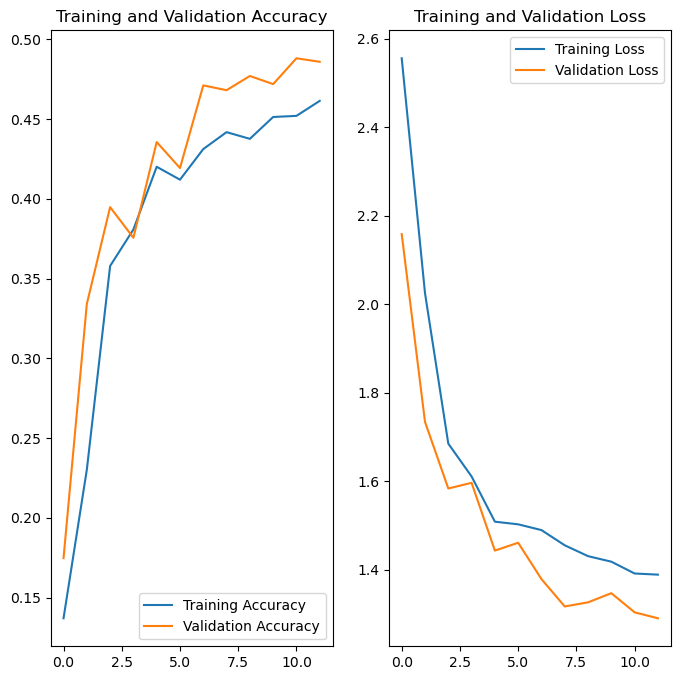

In [13]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
# Findings

#Training Accuracy:
#The training accuracy increased , stabilizing around 46%

#Validation Accuracy:
#Validation accuracy reached 48%, slightly better than the training accuracy, indicating there is no strong evidence of overfitting.


#Evidence of Underfitting:
#Both training and validation accuracy are relatively low.
#The gap between training and validation accuracy/loss is small, indicating that the model isn't overfitting.
#The model might not yet be complex enough or trained for enough epochs.


# Issue of under fitting did not go.
# need to increase the model complexity